In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import pytorch_lightning as pl
from torch_geometric.loader import DataLoader
from torch.utils.data import DataLoader as DL
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
node_embeddings = torch.load('./Output/node_embeddings_initial.pt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
node_embeddings = node_embeddings.to(device)

print(f"Node Embeddings Shape: {node_embeddings.shape}")


/tmp/ipykernel_30834/3061992400.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  node_embeddings = torch.load('./Output/node_embeddings_initial.pt')


Node Embeddings Shape: torch.Size([105220, 256])


In [3]:
## Define the population-level graph model
class PopulationLevelGraph(pl.LightningModule):
    def __init__(self, embedding_dim, latent_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.latent_dim = latent_dim

        ## map node embedding to lower-dimensional latent space
        self.latent_transform = nn.Sequential(
            nn.Linear(self.embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, self.latent_dim),
            nn.ReLU()
        )
        
        ## define Learnable parameters 
        self.temperature = nn.Parameter(torch.tensor(1.0))  # t
        self.threshold = nn.Parameter(torch.tensor(0.0))    # θ
        
    def compute_population_graph(self, graph_representations):
        """
        Compute the weighted adjacency matrix (A_p) based on input graph representations.
        """
        # Project into latent space
        latent_space = self.latent_transform(graph_representations)
        
        # Compute pairwise distances in latent space
        pairwise_distances = torch.cdist(latent_space, latent_space, p=2) ** 2
        
        # Compute adjacency matrix using sigmoid function
        adjacency_matrix = torch.sigmoid(-self.temperature * pairwise_distances + self.threshold)
        return adjacency_matrix

    def compute_node_degree_distribution_loss(self, adjacency_matrix):
        """
        Regularize adjacency matrix using Node Degree Distribution Loss (NDDL).
        """
        # Compute node degrees
        degrees = adjacency_matrix.sum(dim=1)

        # Normalize degrees
        std = degrees.std() + 1e-6  # Add epsilon for numerical stability
        normalized_degrees = (degrees - degrees.mean()) / std

        # Define target Gaussian distribution
        target = torch.distributions.Normal(0.0, 1.0)  # Mean=0, Std=1
        target_probs = target.log_prob(normalized_degrees)

        # Compute KL Divergence
        kl_loss = F.kl_div(normalized_degrees.log_softmax(dim=0), target_probs.softmax(dim=0), reduction="batchmean")
        return kl_loss
            
    def training_step(self, batch):
        """
        Training step for the model.
        """
        graph_representations = batch  # Directly use the input graph representations

        # Compute adjacency matrix
        adjacency_matrix = self.compute_population_graph(graph_representations)

        # Compute NDDL
        nddl_loss = self.compute_node_degree_distribution_loss(adjacency_matrix)

        # Sparsity regularization
        sparsity_loss = adjacency_matrix.sum() * 1e-3

        # Total loss
        total_loss = nddl_loss + sparsity_loss
        self.log("train_loss", total_loss)

        return total_loss

    def configure_optimizers(self):
        """
        Define optimizer for training.
        """
        return torch.optim.Adam(self.parameters(), lr=0.001)


In [4]:
# Prepare DataLoader
train_dataset = DL(node_embeddings, batch_size=128, shuffle=True)

# Initialize Model
model = PopulationLevelGraph(embedding_dim=node_embeddings.size(1), latent_dim=128)

# Trainer
early_stopping = pl.callbacks.EarlyStopping(monitor="train_loss", patience=5, mode="min", verbose=True, min_delta=0.001)
trainer = pl.Trainer(max_epochs=50, accelerator="gpu", devices="auto", callbacks=[early_stopping])

# Train Model
trainer.fit(model, train_dataset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-01-13 10:46:33.618285: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736761593.727699   30834 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736761593.759763   30834 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 10:46:34.094426: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
LOCAL_RAN

Training: |          | 0/? [00:00<?, ?it/s]

Metric train_loss improved. New best score: 0.034
Monitored metric train_loss did not improve in the last 5 records. Best score: 0.034. Signaling Trainer to stop.


In [5]:
## Get the adjacency matrix

## set the model to evaluation mode
model.eval
model.to(device)

## get subgraph
num_nodes = 30
sub_node_indices = np.random.choice(len(node_embeddings), num_nodes, replace=False)
sub_node_embeddings = node_embeddings[sub_node_indices]
## compute the adjacency matrix
adjacency_matrix = model.compute_population_graph(sub_node_embeddings)

torch.save(adjacency_matrix, './Output/sub_adjacency_matrix.pt')



/tmp/ipykernel_30834/2355597459.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adjacency_matrix = torch.load('./Output/sub_adjacency_matrix.pt').cpu().detach().numpy()


Mean Value: 1.9661170881590806e-05
Median Value: 0.0


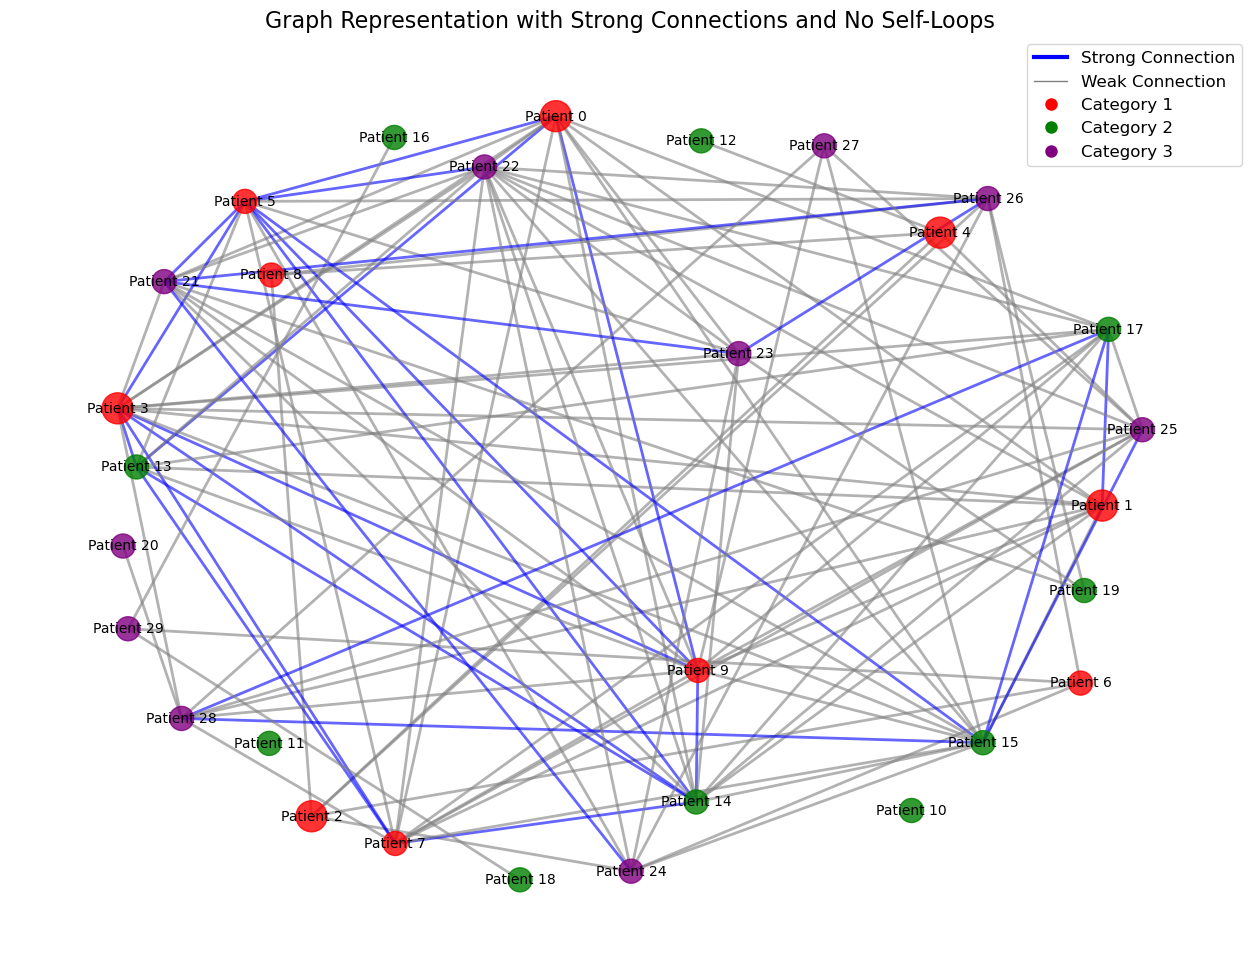

In [6]:
## Visulaize the adjacency matrix
## Load the adjacency matrix
adjacency_matrix = torch.load('./Output/sub_adjacency_matrix.pt').cpu().detach().numpy()

np.savetxt('./Output/sub_adjacency_matrix.csv', adjacency_matrix, delimiter=',')

off_diag = np.triu(adjacency_matrix, k=1)
off_diag = off_diag.flatten()

## Set the threshold
mean_value = np.mean(off_diag)
median_value = np.median(off_diag)
print(f"Mean Value: {mean_value}")
print(f"Median Value: {median_value}")
np.fill_diagonal(adjacency_matrix, 0)

## exclude the meaningless connections
threshold_meaningless = mean_value
adjacency_matrix[adjacency_matrix < threshold_meaningless] = 0

## create graph from adjacency matrix
graph = nx.from_numpy_array(adjacency_matrix)

# Customize node attributes
node_labels = {i: f"Patient {i}" for i in range(graph.number_of_nodes())}
node_colors = ["red" if i < 10 else "green" if i < 20 else "purple" for i in graph.nodes]
node_sizes = [500 if i < 5 else 300 for i in graph.nodes]

# Customize edge attributes based on weights
edges, weights = zip(*nx.get_edge_attributes(graph, "weight").items())
strong_connection_threshold = mean_value *10  # Adjust this threshold for strong connections
edge_colors = ["blue" if w > strong_connection_threshold else "gray" for w in weights]
edge_widths = [2 + 2 * w for w in weights]  # Thickness scales with weight

# Generate a layout for the graph
pos = nx.spring_layout(graph, seed=42)  # Use spring layout for better visualization

# Plot the graph
plt.figure(figsize=(16, 12))
nx.draw_networkx_edges(graph, pos, edge_color=edge_colors, width=edge_widths, alpha=0.6)
nx.draw_networkx_nodes(graph, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=10, font_color="black")

# Add a legend
legend_elements = [
    plt.Line2D([0], [0], color="blue", lw=3, label="Strong Connection"),
    plt.Line2D([0], [0], color="gray", lw=1, label="Weak Connection"),
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="red", markersize=10, label="Category 1"),
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="green", markersize=10, label="Category 2"),
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="purple", markersize=10, label="Category 3"),
]
plt.legend(handles=legend_elements, loc="upper right", fontsize=12)

plt.title("Graph Representation with Strong Connections and No Self-Loops", fontsize=16)
plt.axis("off")  # Hide axis for cleaner visualization
plt.show()
